# Noisy Integrable Traceout

In [8]:
import sys
sys.path.insert(0, '../../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import tensorflow as tf
import random
import pickle as pkl

from qiskit.quantum_info import Operator, Statevector
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from quantum_tools import circuit_to_matrix
from kraus_channels import isomery_to_kraus, KrausMap, DilutedKrausMap
from quantum_channel import ConcatChannel, DilutedChannel, IdentityChannel, ChoiMapStatic
from utils import numberToBase, saver, loader
from spectrum import complex_spacing_ratio, channel_spectrum, Spectrum, mean_spacing, coat_spectrum, spectrum_to_radial, spectrum_to_angular
from qiskit.circuit.library import iSwapGate, XGate, YGate, HGate, CXGate, RGate, RZGate

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=1)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [1]:
from scipy.optimize import curve_fit

def func1(x, a):
    return a*x**2

def func2(x, a, b):
    return a*np.sqrt(x) + b

In [2]:
def stats(radial_list, angular_list):
    N = len(radial_list)
    r_mean_list = []
    a_mean_list = []
    for radial, angular in zip(radial_list, angular_list):
        r_mean = np.mean(radial)
        a_mean = -np.mean(np.cos(angular))

        r_mean_list.append(r_mean)
        a_mean_list.append(a_mean)

    r_mean = np.mean(r_mean_list)
    r_std = np.std(r_mean_list)/np.sqrt(N)

    a_mean = np.mean(a_mean_list)
    a_std = np.std(a_mean_list)/np.sqrt(N)

    return r_mean, r_std, a_mean, a_std

## Circuits

In [3]:
def kraus_marginalize(kraus_map):

    kraus_tensor = kraus_map.kraus[0]

    rank = kraus_tensor.shape[0]
    d = kraus_tensor.shape[1]
    kraus_list = []

    for i in range(rank):
        for j in range(2):
            kraus = kraus_tensor[i, j*(d//2):(j+1)*(d//2), :(d//2)]
            kraus = tf.expand_dims(kraus, axis=0)
            kraus_list.append(kraus)

    kraus = tf.concat(kraus_list, axis=0)
    kraus = tf.expand_dims(kraus, axis=0)
    kraus_map = KrausMap(d//2, 2*rank, trainable=False, generate=False)
    kraus_map.kraus = kraus

    return kraus_map


def integrable_circuit(n, L):
    theta_list = [np.random.uniform(-np.pi, np.pi, n) for i in range(L)]
    sqrt_iSWAP = iSwapGate().power(1 / 2)

    circuit = qk.QuantumCircuit(n)
    for i, theta in enumerate(theta_list):

        offset = i%2
        for j in range(n):
            circuit.rz(theta[j], j)

        for j in range((n - offset) // 2):
            circuit.append(sqrt_iSWAP, [2 * j + offset, 2 * j + 1 + offset])


    return circuit


def sample_csr(n, reps, circuit_type, p=0.5, L=5, noise_rank=2):

    d = 2**n

    map_list = []
    spectra_list = []
    csr_list = []

    U_list = []
    for _ in range(reps):
        circuit = circuit_type(n+1, L)
        U = Operator(circuit).data
        U_list.append(U)

    for i in tqdm(range(reps)):
        U = U_list[i]
        
        kraus_chaos = KrausMap(2*d, rank=noise_rank)
        kraus_map = DilutedKrausMap(U, c=1-p, kraus_part = kraus_chaos)
        
        kraus_map = kraus_marginalize(kraus_map)

        map_list.append(kraus_map)
        
        spectrum = channel_spectrum(kraus_map)
        spectra_list.append(spectrum)
        csr = complex_spacing_ratio(spectrum, log=False)
        csr_list.append(csr)

    return  map_list, spectra_list, csr_list

## Reproduce Observed Data

## Integrable

In [5]:
popt1 = [0.0324, 0.5649]
popt2 = [3.8643e-04, 2.1435e+00, 1.2948e+01]

In [6]:
def emulate(L, reps):
    n = 4

    CNOTS = 4*L
    p = func1(CNOTS, *popt1)
    r = ceil(func2(CNOTS, *popt2))


    _, spectra_integrable_list, csr_integrable_list = sample_csr(n, reps, integrable_circuit, p=p, L=L, noise_rank=r)

    radial = spectrum_to_radial(csr_integrable_list)
    angular = spectrum_to_angular(csr_integrable_list)

    r_mean, r_std, a_mean, a_std = stats(radial, angular)

    csr_integrable = Spectrum(csr_integrable_list)
    csr_integrable_coat = coat_spectrum(csr_integrable, sigma = 0.05)

    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    plt.imshow(csr_integrable_coat, interpolation='nearest')
    plt.show()

    return r_mean, r_std, a_mean, a_std

In [22]:
n = 4
reps = 1000

_, spectra_integrable_list, csr_integrable_list = sample_csr(n, reps, integrable_circuit, p=0.001, L=5, noise_rank=1)

radial = spectrum_to_radial(csr_integrable_list)
angular = spectrum_to_angular(csr_integrable_list)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
r_mean, r_std, a_mean, a_std = stats(radial, angular)

In [21]:
r_mean, r_std, a_mean, a_std

(0.5709012942456195,
 0.015626698863030503,
 -0.10304293939286385,
 0.01715333858574695)

  0%|          | 0/1000 [00:00<?, ?it/s]

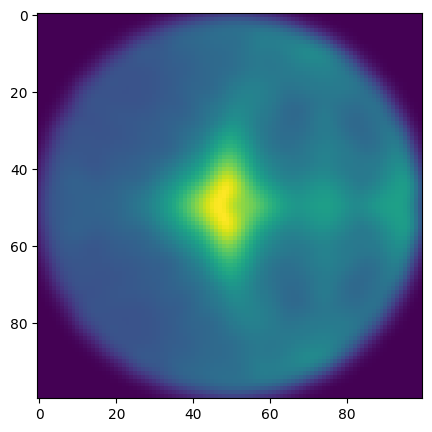

In [16]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L = 5
reps = 1000

r_mean_L5, r_std_L5, a_mean_L5, a_std_L5 = emulate(L, reps)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

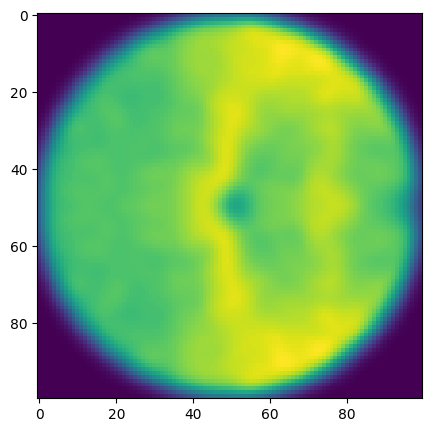

In [30]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=10
reps = 1000

r_mean_L10, r_std_L10, a_mean_L10, a_std_L10 = emulate(L, reps)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

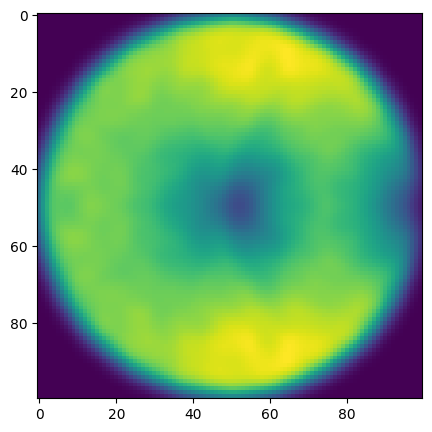

In [31]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=20
reps = 1000

r_mean_L20, r_std_L20, a_mean_L20, a_std_L20 = emulate(L, reps)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

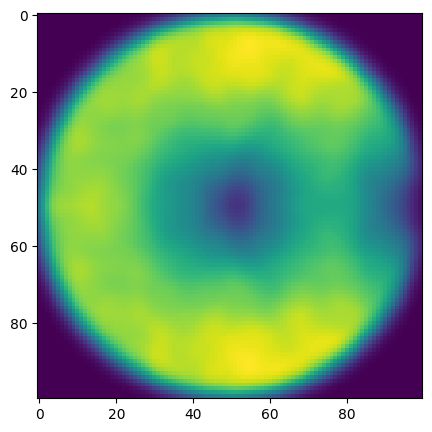

In [32]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=30
reps = 1000

r_mean_L30, r_std_L30, a_mean_L30, a_std_L30 = emulate(L, reps)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

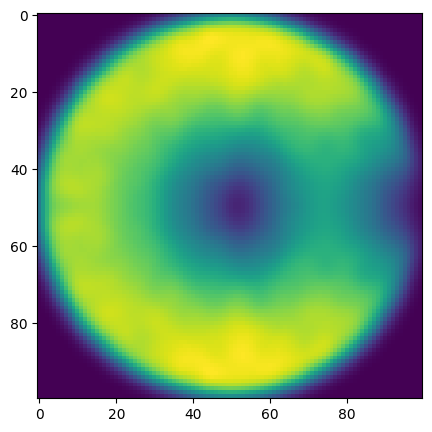

In [33]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=40
reps = 1000

r_mean_L40, r_std_L40, a_mean_L40, a_std_L40 = emulate(L, reps)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

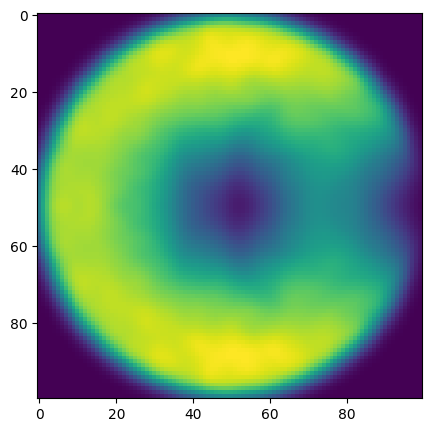

In [42]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=50
reps = 1000

r_mean_L50, r_std_L50, a_mean_L50, a_std_L50 = emulate(L, reps)
    

In [43]:
r_poisson, a_poisson = 2/3, 0
r_AI, a_AI = 0.7281304166154063, 0.19742124056951219
r_FF, a_FF = 0.615310151004864, -0.08983735962503564

r_mean_list = [r_mean_L5, r_mean_L10, r_mean_L20, r_mean_L30, r_mean_L40, r_mean_L50]
a_mean_list = [a_mean_L5, a_mean_L10, a_mean_L20, a_mean_L30, a_mean_L40, a_mean_L50]

saver([r_mean_list, a_mean_list], '../data/diluted_scatter.data')


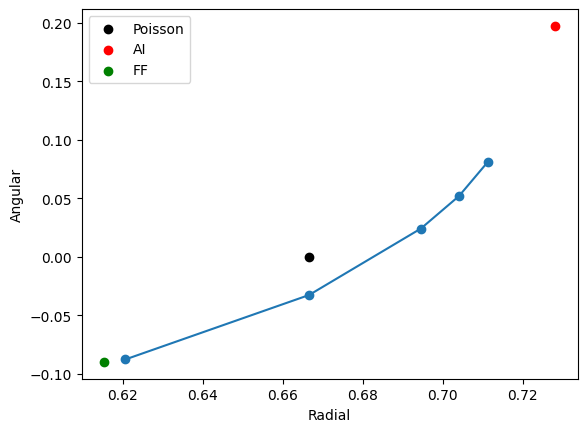

In [ ]:
r_mean_list, a_mean_list = loader('data/diluted_scatter.data')

plt.plot(r_mean_list, a_mean_list, "o-")

plt.scatter(r_poisson, a_poisson, label='Poisson', color='black')
plt.scatter(r_AI, a_AI, label='AI', color='red')
plt.scatter(r_FF, a_FF, label='FF', color='green')

plt.xlabel('Radial')
plt.ylabel('Angular')
plt.legend()
plt.grid()
plt.show()

## More data

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=6
reps = 1000

r_mean_L6, r_std_L6, a_mean_L6, a_std_L6 = emulate(L, reps)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

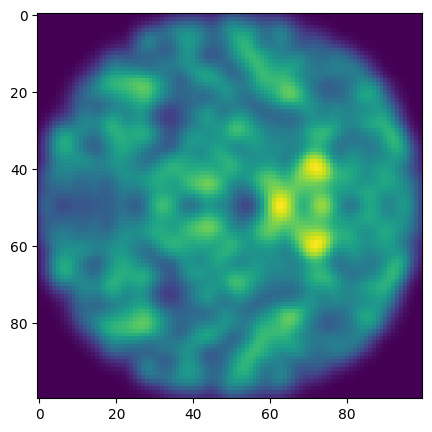

In [12]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=7
reps = 1000

r_mean_L7, r_std_L7, a_mean_L7, a_std_L7 = emulate(L, reps)

  0%|          | 0/10 [00:00<?, ?it/s]

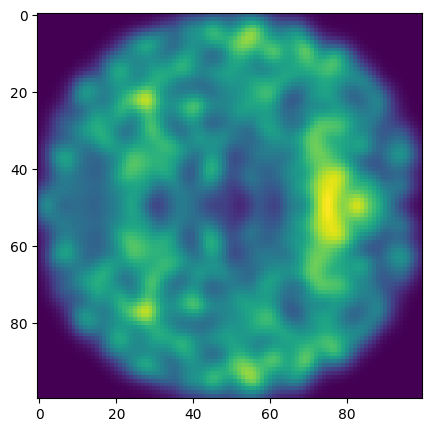

In [13]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=8
reps = 1000

r_mean_L8, r_std_L8, a_mean_L8, a_std_L8 = emulate(L, reps)

  0%|          | 0/10 [00:00<?, ?it/s]

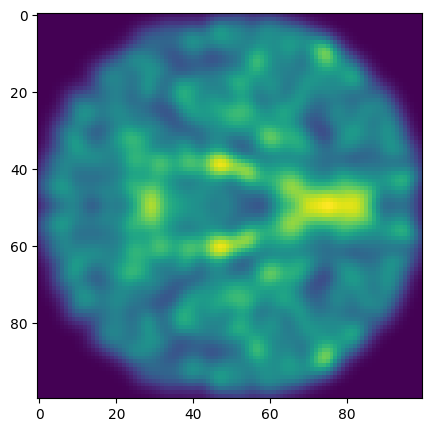

In [14]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=9
reps = 1000

r_mean_L9, r_std_L9, a_mean_L9, a_std_L9 = emulate(L, reps)

  0%|          | 0/10 [00:00<?, ?it/s]

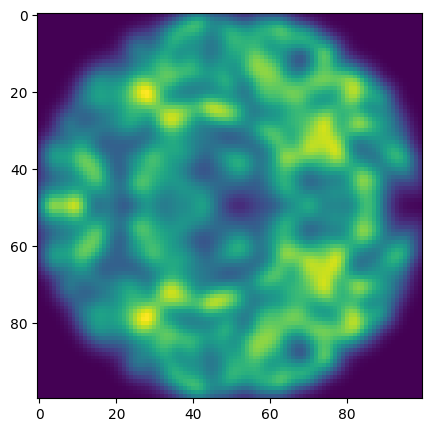

In [15]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=15
reps = 1000

r_mean_L15, r_std_L15, a_mean_L15, a_std_L15 = emulate(L, reps)

  0%|          | 0/10 [00:00<?, ?it/s]

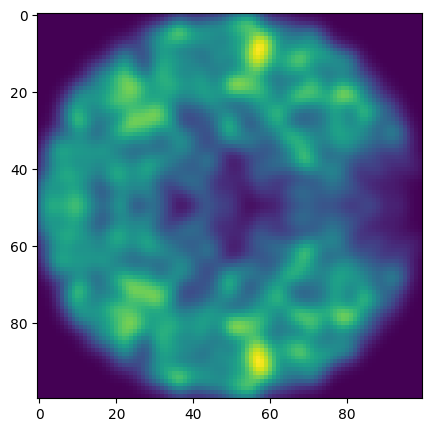

In [16]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

L=60
reps = 1000

r_mean_L60, r_std_L60, a_mean_L60, a_std_L60 = emulate(L, reps)

In [18]:
r_mean_list = [r_mean_L6, r_mean_L7, r_mean_L8, r_mean_L9, r_mean_L15, r_mean_L60]
a_mean_list = [a_mean_L6, a_mean_L7, a_mean_L8, a_mean_L9, a_mean_L15, a_mean_L60]

saver([r_mean_list, a_mean_list], '../data/diluted_scatter_more.data')


## Book Keeping

In [10]:
[[r_mean_L6, r_mean_L7, r_mean_L8, r_mean_L9, r_mean_L15, r_mean_L60], 
 [a_mean_L6, a_mean_L7, a_mean_L8, a_mean_L9, a_mean_L15, a_mean_L60]] = loader('../data/diluted_scatter_more.data')


[[r_mean_L5, r_mean_L10, r_mean_L20, r_mean_L30, r_mean_L40, r_mean_L50],
 [a_mean_L5, a_mean_L10, a_mean_L20, a_mean_L30, a_mean_L40, a_mean_L50]] = loader('../data/diluted_scatter.data')

In [11]:
r_mean_list = [r_mean_L5, r_mean_L6, r_mean_L7, r_mean_L8, r_mean_L9, r_mean_L10, r_mean_L15, r_mean_L20, r_mean_L30, r_mean_L40, r_mean_L50, r_mean_L60]
a_mean_list = [a_mean_L5, a_mean_L6, a_mean_L7, a_mean_L8, a_mean_L9, a_mean_L10, a_mean_L15, a_mean_L20, a_mean_L30, a_mean_L40, a_mean_L50, a_mean_L60]

NameError: name 'r_poisson' is not defined

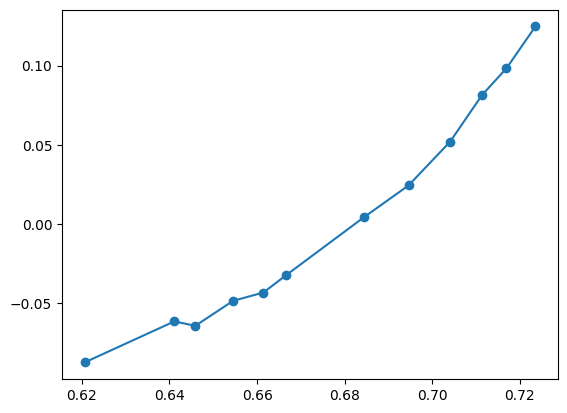

In [12]:
plt.plot(r_mean_list, a_mean_list, "o-")

plt.scatter(r_AI, a_AI, label='AI', color='red')
plt.scatter(r_FF, a_FF, label='FF', color='green')

plt.xlabel('Radial')
plt.ylabel('Angular')
plt.legend()
plt.grid()
plt.show()